# pdf

> pdf file and associated images    

In [1]:
#| default_exp pdf

In [2]:
#| export
from usgs_extract.utilities import convert_page 

In [3]:
#| hide
from nbdev.showdoc import *
from fastcore.test import test_eq
from fastcore.utils import *
from PyPDF2 import PdfReader
from multiprocessing import Pool, cpu_count
import time
from tqdm import tqdm
import PIL

In [4]:
#| export
class PDF():
    " A class for PDFs. "
    def __init__(self, pdf_path, output_folder=None):
        self.pdf_path = pdf_path
        self.output_folder = output_folder
        
    def get_length(self)->int:
        " Get the number of pages in the PDF. "
        pdf = PdfReader(self.pdf_path)
        return len(pdf.pages)
    
    # Define the property length using the get_length function
    length = property(get_length)
    
    # define the __len__ method
    def __len__(self):
        return self.length
    
    # define the __repr__ method
    def __repr__(self):
        return f"PDF({self.pdf_path})"

In [5]:
pdf_dir = "samples/"
all_pdf_files = [pdf_dir + f for f in os.listdir(pdf_dir) if f.endswith(".pdf")]
print(all_pdf_files)

['samples/Hall et al., 1911_only data tables.pdf', 'samples/Lipincott, 1905.pdf', 'samples/sample_01_inline.pdf', 'samples/simpson et al., 1929.pdf', 'samples/sample_03_rotated_complex.pdf', 'samples/BEACH Slides copy.pdf', 'samples/sample_02_rotated.pdf']


In [6]:
pdf = PDF(all_pdf_files[0])
test_eq(pdf.length, 16)
test_eq(len(pdf), 16)
test_eq(repr(pdf), f"PDF({all_pdf_files[0]})")

In [7]:
#| export
#| hide
@patch
def to_images(self:PDF, # PDF object
            start_page:int=None, # Set to None to convert all pages
            end_page:int=None, # Set to None to convert all pages
            debug:bool=False, # Set to True to print debug messages
            cache_on_disk=False # Set to True to cache images on disk

            )->list: # Return a list of image paths
    """ Convert a PDF to images using multiprocessing."""
    def debug_print(message):
        if debug:
            print(message)
    # Only run if the PDF has not already been converted to images
    # Check to see if _images has data
    if not hasattr(self, "_images") or not hasattr(self, "_image_paths"):        
        # Extract base filename without extension
        base_filename = os.path.splitext(os.path.basename(self.pdf_path))[0]

        # Determine the number of pages to convert
        if start_page and end_page:
            pages = range(start_page, end_page + 1)
        elif start_page:
            pages = range(start_page, len(self))  # Placeholder for actual page count
        elif end_page:
            pages = range(1, end_page + 1)
        else:
            pages = range(1, len(self) + 1)  # Assume self knows the length

        if debug:
            debug_print(f"Converting pages {list(pages)} of {self.pdf_path} to images")

        start_time = time.time()
        with Pool(cpu_count()) as pool:
            tasks = [pool.apply_async(convert_page, ((self.pdf_path, self.output_folder, page_num),)) for page_num in pages]
            image_paths = []
            images = []
            # Initialize tqdm progress bar
            for task in tqdm(tasks, total=len(tasks), desc="Converting Pages"):
                image_path, image = task.get()  # Block until each task is complete
                if image_path and image:
                    image_paths.append(image_path)
                    images.append(image)
                if debug:
                    current_page = pages.start + len(image_paths) - 1
                    debug_print(f"Finished page {current_page}")

        if debug:
            debug_print(f"All tasks completed. Total processing time: {time.time() - start_time:.2f} seconds")

        self._image_paths = image_paths
        self._images = images
        if cache_on_disk:
            self._cache_images() 
    else:
        if debug:
            debug_print("Images already converted")
    return self._images

@patch
def _cache_images(self:PDF,
                  clear_images=False, # Set to True to clear images from memory after caching
                  debug=False # Set to True to print debug messages
                  )->None:
    " Cache images on disk. "
    if not hasattr(self, "image_paths"):
        raise AttributeError("No images to cache. Run the to_images method first.")
    if not hasattr(self, "output_folder"):
        raise AttributeError("No output folder specified. Set the output_folder attribute first.")
    for image, image_path in zip(self.images, self.image_paths):
        # Check to see if the image is already saved:
        if not os.path.exists(image_path):
            image.save(image_path)
            if debug:
                print(f"Saved image to {image_path}")
        else:
            if debug:
                print(f"Image already saved to {image_path}")
    if clear_images:
        if debug:
            print("Clearing images from memory")
        self.clear_images()

@patch
def clear_images(self:PDF)->None:
    " Clear images from memory. "
    if hasattr(self, "images"):
        del self.images
    if hasattr(self, "image_paths"):
        del self.image_paths

In [8]:
#| export
@patch(as_prop=True)
def images(self:PDF)->list:
    " Get the images from the PDF. "
    if not hasattr(self, "_images"):
        self._images = self.to_images()
    return self._images

@patch(as_prop=True)
def image_paths(self:PDF)->list:
    " Get the image paths from the PDF. "
    if not hasattr(self, "_image_paths"):
        self.to_images()
    return self._image_paths


@patch
def show_page(self:PDF,
              num=1, scaling=0.25):
    " Show the image corresponding to a page of the pdf"
    if not hasattr(self, "_images"):
        self._images=self.to_images()
    image = self._images[num-1]
    width, height = image.size
    display(image.resize((int(scaling * width), int(scaling * height))))


In [9]:
show_doc(PDF.to_images)

---

### PDF.to_images

>      PDF.to_images (start_page:int=None, end_page:int=None, debug:bool=False,
>                     cache_on_disk=False)

Convert a PDF to images using multiprocessing.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| start_page | int | None | Set to None to convert all pages |
| end_page | int | None | Set to None to convert all pages |
| debug | bool | False | Set to True to print debug messages |
| cache_on_disk | bool | False | Set to True to cache images on disk |
| **Returns** | **list** |  | **Return a list of image paths** |

In [10]:
pdf = PDF(all_pdf_files[0], output_folder="samples/output/")
start_time = time.time()
images = pdf.to_images(debug=False)
print(f"Total processing time: {time.time() - start_time:.2f} seconds")

Converting Pages: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

Total processing time: 3.10 seconds


In [11]:
# Test that the images are stored in the images attribute
test_eq(len(pdf.images), 16)
test_eq(len(pdf.image_paths), 16)

In [12]:
# Test that the to_image function can be called multiple times without reprocessing
start_time = time.time()
images = pdf.to_images(debug=False)
print(f"Total processing time: {time.time() - start_time:.2f} seconds")

Total processing time: 0.00 seconds


In [13]:
# Test that the to_image function returns a list of images:
test_eq(len(images), 16)
test_eq(type(images), list)
test_eq(type(images[0]), PIL.PngImagePlugin.PngImageFile)

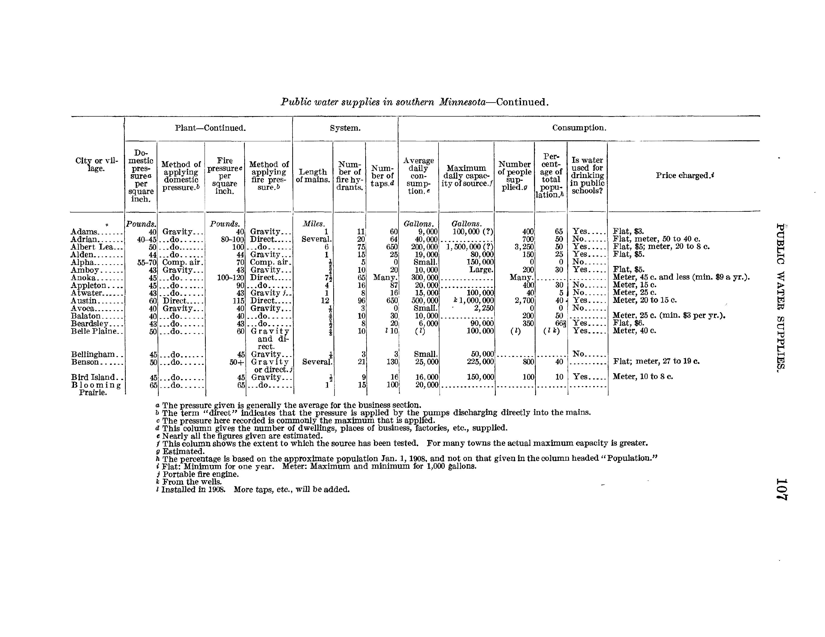

In [14]:
pdf.show_page(10)

In [15]:
# Test that the images are stored in the images attribute
test_eq(len(pdf.image_paths), 16)
test_eq(len(pdf.images), 16)


In [16]:
pdf = PDF(all_pdf_files[0], output_folder="samples/output/")
pdf.image_paths

Converting Pages: 100%|██████████| 16/16 [00:02<00:00,  5.96it/s]


['samples/output/Hall et al., 1911_only data tables_page_1.png',
 'samples/output/Hall et al., 1911_only data tables_page_2.png',
 'samples/output/Hall et al., 1911_only data tables_page_3.png',
 'samples/output/Hall et al., 1911_only data tables_page_4.png',
 'samples/output/Hall et al., 1911_only data tables_page_5.png',
 'samples/output/Hall et al., 1911_only data tables_page_6.png',
 'samples/output/Hall et al., 1911_only data tables_page_7.png',
 'samples/output/Hall et al., 1911_only data tables_page_8.png',
 'samples/output/Hall et al., 1911_only data tables_page_9.png',
 'samples/output/Hall et al., 1911_only data tables_page_10.png',
 'samples/output/Hall et al., 1911_only data tables_page_11.png',
 'samples/output/Hall et al., 1911_only data tables_page_12.png',
 'samples/output/Hall et al., 1911_only data tables_page_13.png',
 'samples/output/Hall et al., 1911_only data tables_page_14.png',
 'samples/output/Hall et al., 1911_only data tables_page_15.png',
 'samples/output/Ha

In [17]:
#| hide
import nbdev; nbdev.nbdev_export()